In [100]:
import pickle, os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import poisson

In [91]:
path = "C:/data/SiPM/waveforms/20240320/"
filename_list = ["LED_data_vb_28V_amp0.pkl",
                 "LED_data_vb_28V_amp1.3.pkl",
                 "LED_data_vb_28V_amp1.35.pkl",
                 "LED_data_vb_28V_amp1.4.pkl",
                 "LED_data_vb_28V_amp1.45.pkl",
                 "LED_data_vb_28V_amp1.5.pkl",
                 "LED_data_vb_28V_amp1.55.pkl",
                 "LED_data_vb_28V_amp1.6.pkl",
                 "LED_data_vb_28V_amp1.65.pkl"]
amp_list  = [0, 1.3, 1.35, 1.4, 1.45, 1.5, 1.55, 1.6, 1.65]

In [92]:
amps_dict = {}
for j,filename in enumerate(filename_list):
    
    with open(os.path.join(path, filename), 'rb') as fin:
        data_dict = pickle.load(fin)

    nwaveforms = len( data_dict.keys() ) - 1
    print("Got %d waveforms"%nwaveforms + " for file "+filename)

    amps_dict[amp_list[j]] = {'nwaveforms': nwaveforms, 'data_dict': data_dict}


Got 40000 waveforms for file LED_data_vb_28V_amp0.pkl
Got 40000 waveforms for file LED_data_vb_28V_amp1.3.pkl
Got 40000 waveforms for file LED_data_vb_28V_amp1.35.pkl
Got 40000 waveforms for file LED_data_vb_28V_amp1.4.pkl
Got 40000 waveforms for file LED_data_vb_28V_amp1.45.pkl
Got 40000 waveforms for file LED_data_vb_28V_amp1.5.pkl
Got 40000 waveforms for file LED_data_vb_28V_amp1.55.pkl
Got 40000 waveforms for file LED_data_vb_28V_amp1.6.pkl
Got 40000 waveforms for file LED_data_vb_28V_amp1.65.pkl


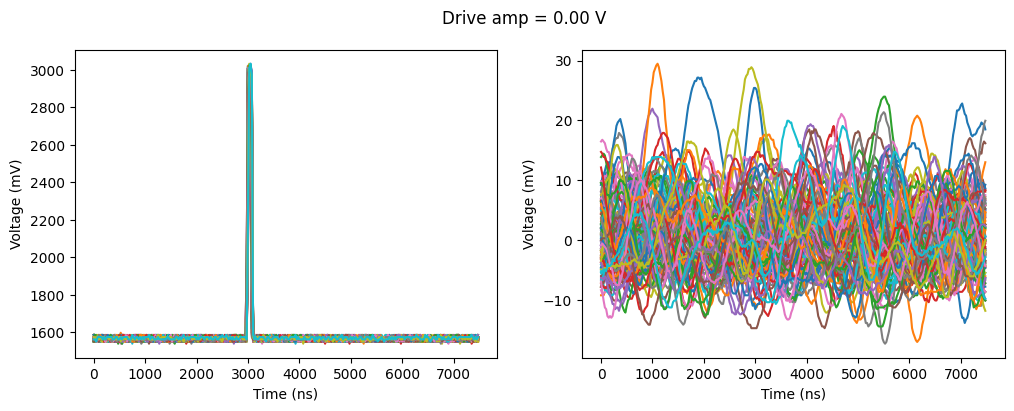

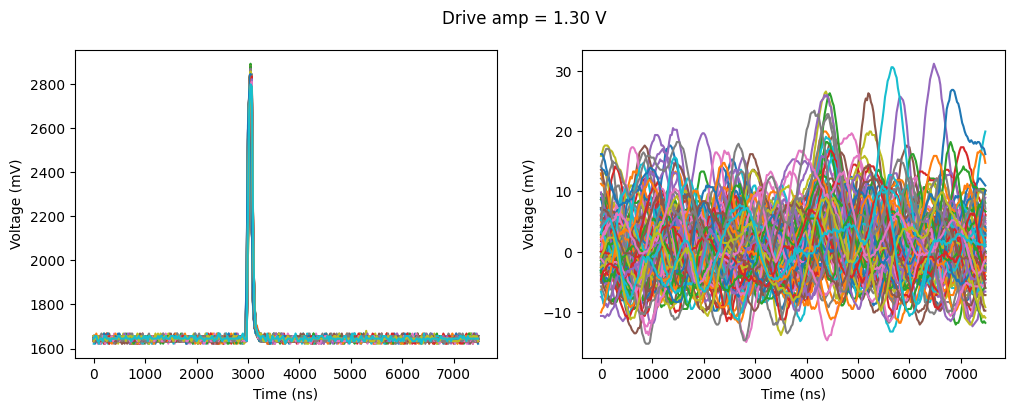

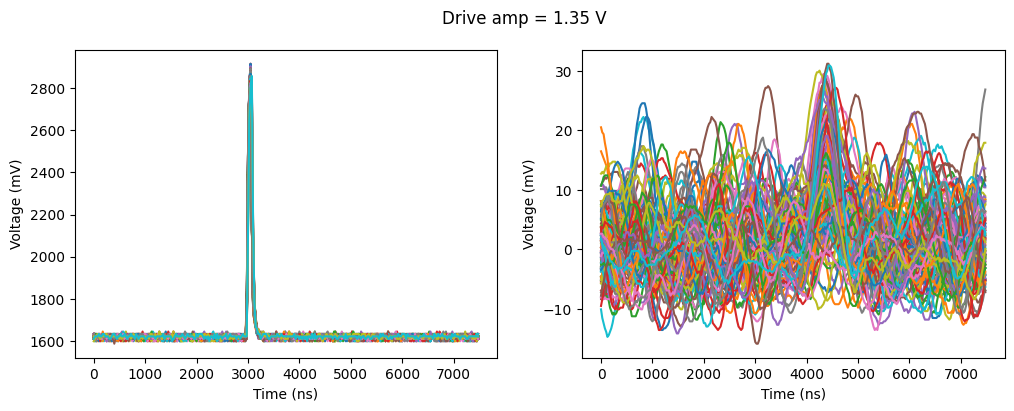

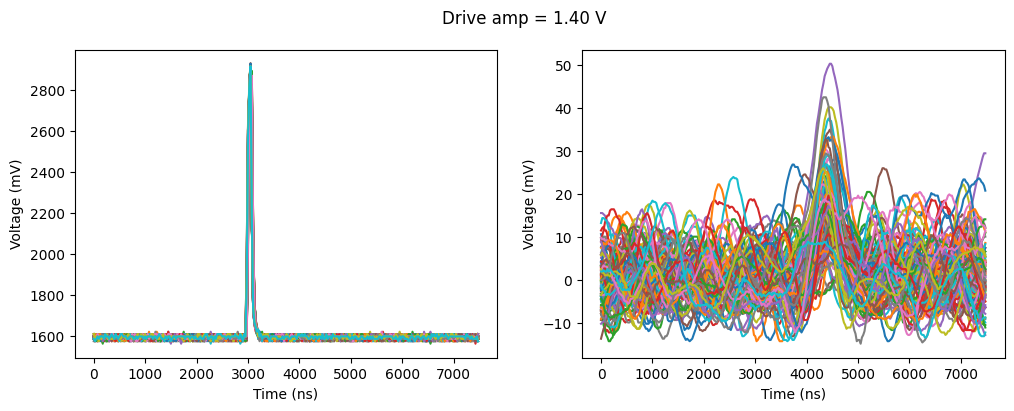

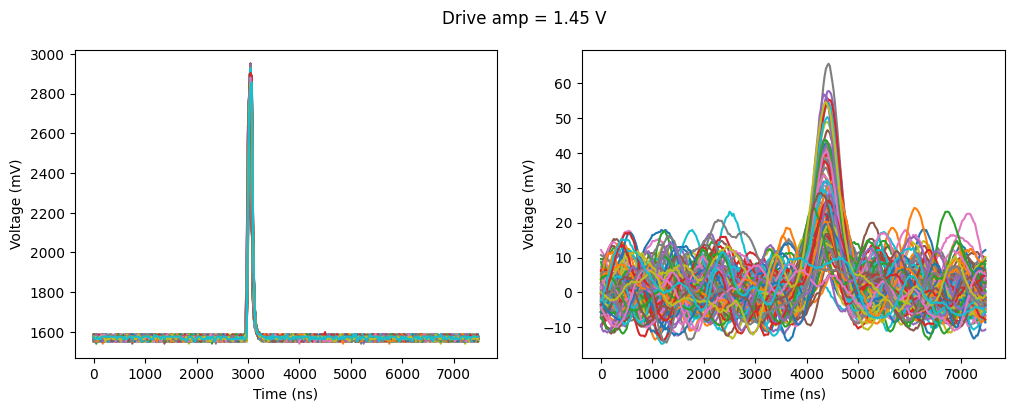

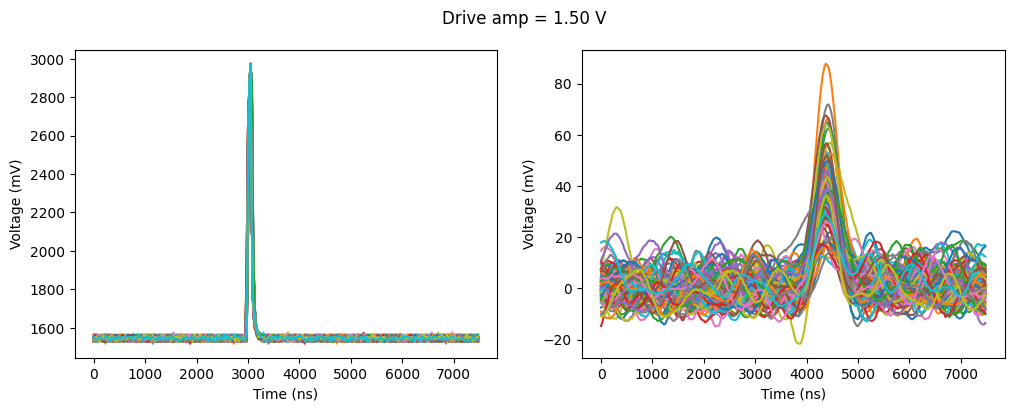

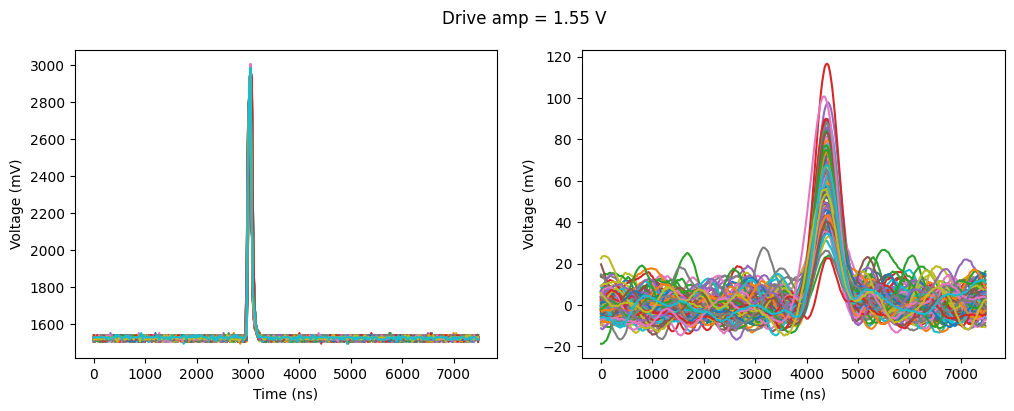

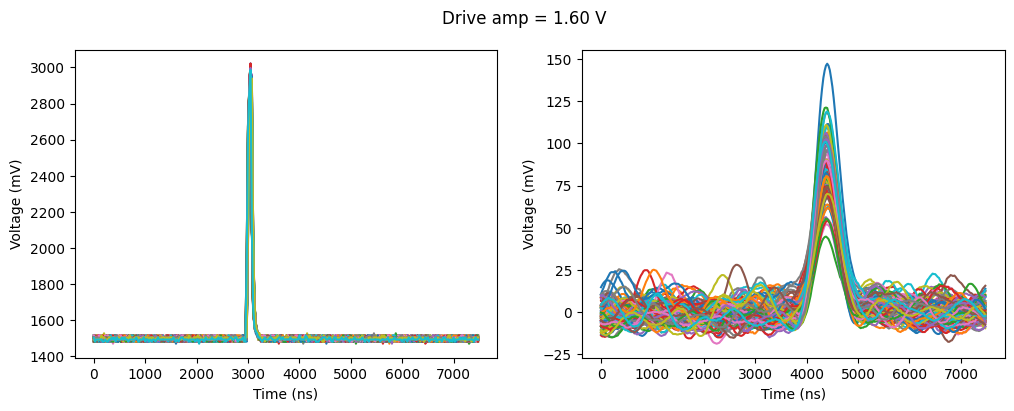

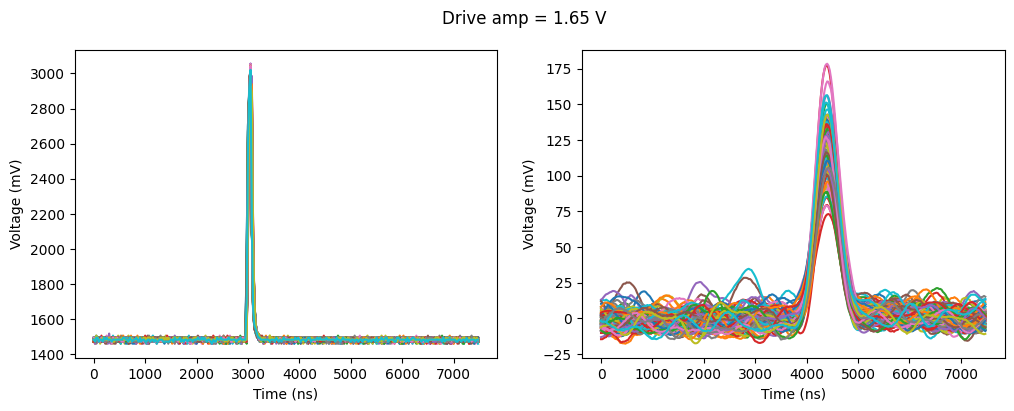

In [93]:
make_plot = True
max_figs = 100

for amp in amp_list:

    nwaveforms = amps_dict[amp]['nwaveforms']
    data_dict = amps_dict[amp]['data_dict']

    if(nwaveforms > max_figs):
        downsamp = int(nwaveforms/max_figs)
    else:
        downsamp = 1

    if(make_plot):

        plt.figure(figsize=(12,4))
        plt.subplot(1,2,1)
        for j in range(nwaveforms):
            if(j%downsamp != 0): continue
            plt.plot(data_dict['time'], data_dict[j][0])
            plt.xlabel('Time (ns)')
            plt.ylabel('Voltage (mV)')

        plt.subplot(1,2,2)
        for j in range(nwaveforms):
            if(j%downsamp != 0): continue
            plt.plot(data_dict['time'], data_dict[j][1])
            plt.xlabel('Time (ns)')
            plt.ylabel('Voltage (mV)')

        plt.suptitle("Drive amp = %.2f V"%amp)



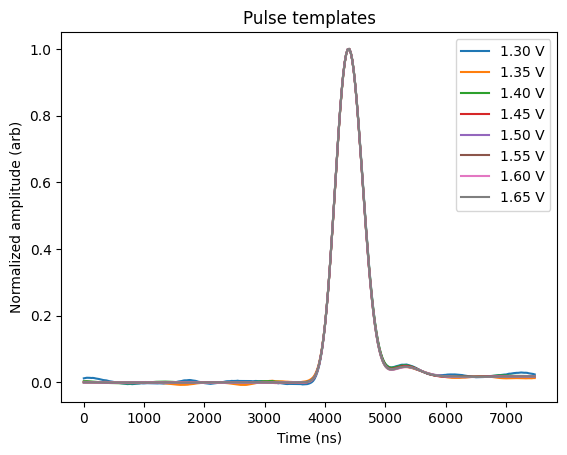

In [94]:
template_dict = {}

plt.figure()
for amp in amp_list:

    if(amp == 0 ):
        continue

    nwaveforms = amps_dict[amp]['nwaveforms']
    data_dict = amps_dict[amp]['data_dict']

    ## make average template
    template = np.zeros_like(data_dict['time'])

    nwfm = 0
    for j in range(nwaveforms):

        cdat = data_dict[j][1]

        ## throw out bad traces
        #if np.max(cdat) > 0:
        #    continue

        template += cdat
        nwfm += 1

    template /= nwfm
    template -= np.median(template[:100])
    template /= np.max(template)

    plt.plot(data_dict['time'], template, label="%.2f V"%amp)
    plt.xlabel('Time (ns)')
    plt.ylabel('Normalized amplitude (arb)')

    template_dict[amp] = template

plt.title("Pulse templates")
plt.legend()
plt.show()

In [95]:
def gauss_fun(x, A, mu, sig):
    return A*np.exp(-(x-mu)**2/(2*sig**2))

In [137]:
def smeared_poiss(x, A, mu, cal=4.6, sig=6.57):
    
    scaled_vals = x/cal
    
    int_vals = np.arange(3*mu)
    
    out_vals = np.zeros_like(x)
    for k in int_vals:
        prob = poisson.pmf(k, mu, loc=0)

        out_vals += prob*gauss_fun(scaled_vals, 1, k, sig/cal)

    return A*out_vals
    

In [116]:
color_list = plt.rcParams['axes.prop_cycle'].by_key()['color']

Gauss fit gives sigma:  6.568919165953699
1.4459898903775332
2.273316824851247
3.5567339448576947
5.503059888316646
8.508546792621308
12.758718631532872
18.806657900074246
26.970967127264057


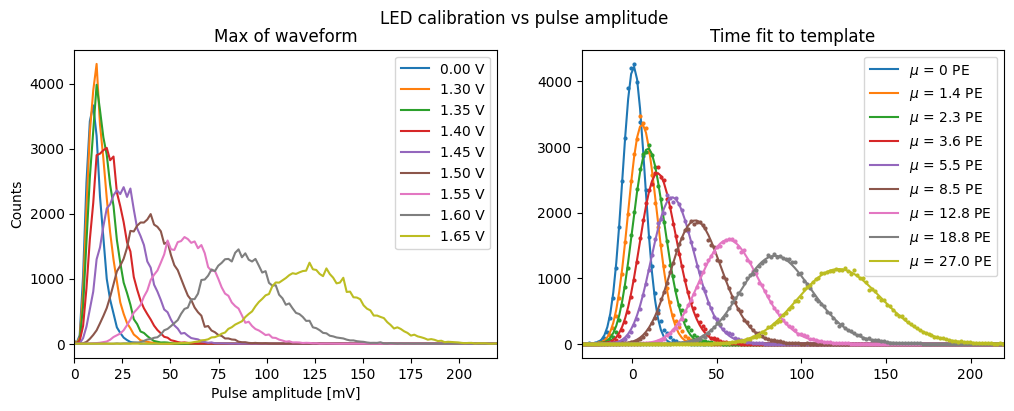

In [138]:
plt.figure(figsize=(12,4))

for aidx, amp in enumerate(amp_list):

    nwaveforms = amps_dict[amp]['nwaveforms']
    data_dict = amps_dict[amp]['data_dict']

    recon_amps = []
    window  = [4000, 5000]

    mpts = (data_dict['time']>window[0]) & (data_dict['time']<window[1])


    for j in range(nwaveforms):

        cdat = data_dict[j][1]
        
        ## baseline subtract
        cdat -= np.median(cdat[:100])

        fit = np.sum( cdat*template ) / np.sum(template**2)

        midx = np.argmax(np.abs(cdat[mpts]))
        max_val = cdat[mpts][midx]
        recon_amps.append( [max_val, fit] )

    recon_amps = np.array(recon_amps)

    bins = np.linspace(-50,300,200)
    bc = bins[:-1] + np.diff(bins)

    h_max, be = np.histogram( recon_amps[:,0], bins=bins )
    h_fit, be = np.histogram( recon_amps[:,1], bins=bins )

    plt.subplot(1,2,1)
    plt.plot(bc, h_max, color=color_list[aidx], label="%.2f V"%amp)
    plt.xlim(0,220)
    plt.subplot(1,2,2)
    plt.plot(bc, h_fit, 'o', color=color_list[aidx], ms=2)
    plt.xlim(-30,220)

    if(amp == 0):
        bp, bcov = curve_fit(gauss_fun, bc, h_fit, p0=[100,0,10])
        sig_guess = bp[2]
        plt.plot(bc, gauss_fun(bc, *bp), color=color_list[aidx], label=r"$\mu$ = 0 PE"%bp[1])
        print("Gauss fit gives sigma: ", bp[2])
    
    else:
        cal_guess = 5.5
        if(aidx == 1):
            median_guess = 1.5
        else:
            median_guess = np.median(recon_amps[:,1])/cal_guess
        spars = [3000, median_guess]
        bp, bcov = curve_fit(smeared_poiss, bc, h_fit, p0=spars)
        #bp=spars
        print(bp[-1])
        plt.plot(bc, smeared_poiss(bc, *bp), color=color_list[aidx], label=r"$\mu$ = %.1f PE"%bp[1])

plt.subplot(1,2,1)
plt.legend()
plt.xlabel("Pulse amplitude [mV]")
plt.ylabel("Counts")
plt.title("Max of waveform")
plt.subplot(1,2,2)
plt.legend()
plt.title("Time fit to template")
plt.suptitle("LED calibration vs pulse amplitude")
plt.show()